In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

In [2]:
#Sample stocks to examine a pair trade setup for
Symbol1 = 'WY'
Symbol2 = 'LKQ'

In [3]:
#connect to the S&P 500 database file and create an associated cursor
conn = sqlite3.connect("SP500_stats_5y.db")
c = conn.cursor()

In [4]:
def DailyStockPlot(Symbol):
    c.execute("SELECT * FROM "+Symbol.replace('.','_')+"_stats WHERE date_int < 1461")
    stats_df = pd.DataFrame(c.fetchall(), columns = [x[0] for x in c.description])
    
    for i in range(len(stats_df)):
        if stats_df['Close'][i] > stats_df['Open'][i]:
            plotcolor='lime'
        elif stats_df['Open'][i] > stats_df['Close'][i]:
            plotcolor='red'
        else:
            plotcolor='black'
        plt.plot([stats_df['date_int'][i], stats_df['date_int'][i]],
                 [stats_df['High'][i], stats_df['Low'][i]], linewidth=0.75, color=plotcolor)
        plt.plot([stats_df['date_int'][i]-0.5, stats_df['date_int'][i]],
                 [stats_df['Open'][i], stats_df['Open'][i]], linewidth=0.75, color=plotcolor)
        plt.plot([stats_df['date_int'][i], stats_df['date_int'][i]+0.5],
                 [stats_df['Close'][i], stats_df['Close'][i]], linewidth=0.75, color=plotcolor)
    
    plt.xlabel('Days',fontsize=16)
    plt.ylabel(Symbol+' Daily Trade Prices ($)',fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    return stats_df

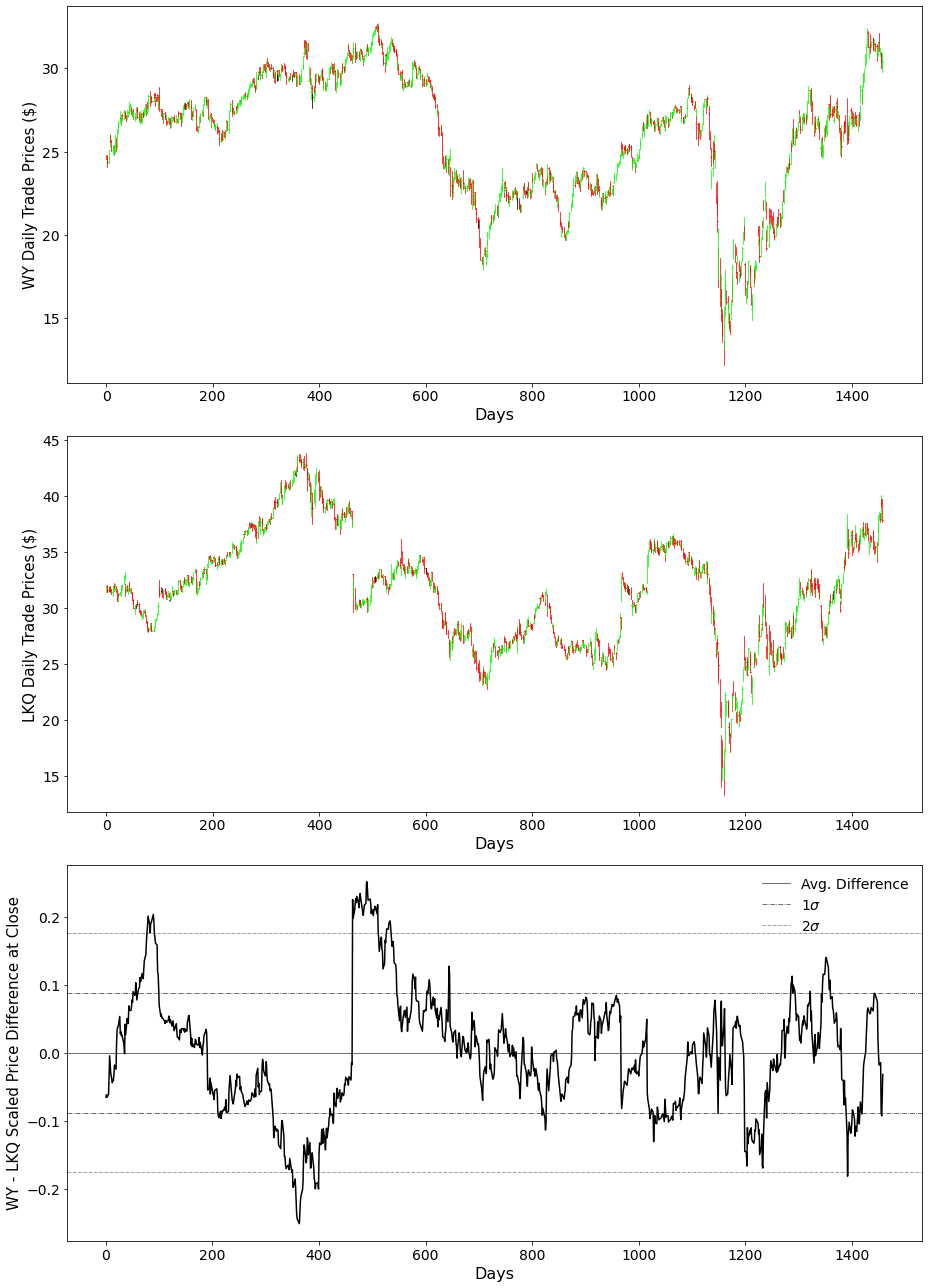

In [5]:
plt.figure(figsize=(13,18))

#Plot Stock 1's value over time
plt.subplot(3,1,1)
stats1_df = DailyStockPlot(Symbol1)


#Plot Stock 2's value over time
plt.subplot(3,1,2)
stats2_df = DailyStockPlot(Symbol2)


#Plot their delta_scaled over time
plt.subplot(3,1,3)

S1Scale = np.mean(stats1_df['Close'])
S2Scale = np.mean(stats2_df['Close'])

sigma = np.std(stats1_df['Close']/S1Scale - stats2_df['Close']/S2Scale)
offset = np.mean(stats1_df['Close']/S1Scale - stats2_df['Close']/S2Scale)

plt.axhline(0.0+offset,linewidth=0.75,linestyle='-',color='0.25',label='Avg. Difference')
plt.axhline(sigma+offset,linewidth=0.75,linestyle='-.',color='0.25',label='$1\sigma$')
plt.axhline(2*sigma+offset,linewidth=0.5,linestyle='-.',color='0.25',label='$2\sigma$')
plt.axhline(-sigma+offset,linewidth=0.75,linestyle='-.',color='0.25')
plt.axhline(-2*sigma+offset,linewidth=0.5,linestyle='-.',color='0.25')

plt.plot(stats1_df['date_int'],
         stats1_df['Close']/S1Scale-stats2_df['Close']/S2Scale,
        color='k')

plt.xlabel('Days',fontsize=16)
plt.ylabel(Symbol1+' - '+Symbol2+' Scaled Price Difference at Close',fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14,loc='best',frameon=False)


plt.tight_layout()
plt.show()

In [6]:
AvgDiff = np.mean(stats1_df['Close']/S1Scale - stats2_df['Close']/S2Scale)

InitFunds = 100000.0
AvailableFunds = InitFunds

CurrentValues = []

Symbol1Position = 'None'
Symbol2Position = 'None'

Symbol1Shares = 0.0
Symbol2Shares = 0.0

LongCost1 = 0.0
LongCost2 = 0.0

ShortFunds1 = 0.0
ShortFunds2 = 0.0

for i in range(len(stats1_df)-1):
    DailyFunds = AvailableFunds
    
    printstats = False
    
    if (stats1_df['Close'][i]/S1Scale - stats2_df['Close'][i]/S2Scale) > AvgDiff:
        #want to short S1 / long S2
        #print('We expect that '+Symbol1+' will drop in price relative to '+Symbol2+' in the near(ish) future.')
        #print("Thus, we'd like to be in a short position for "+Symbol1+" and a long position for "+Symbol2+".")
        
        if Symbol1Position == 'None':
            #Set up a short position worth half of the available funds on symbol 1 shares at the next open
            Symbol1Shares = -0.5*DailyFunds/stats1_df['Open'][i+1]
            ShortFunds1 = 0.5*DailyFunds
            AvailableFunds = AvailableFunds - ShortFunds1
            Symbol1Position = 'Short'
            print('Opening short position on '+Symbol1+': $'+str(round(ShortFunds1,2))+' / '+str(round(-Symbol1Shares,2))+' shares')
            printstats = True
            
        if Symbol1Position == 'Long':
            #Sell currently owned symbol 1 shares at the next open
            print('Closing long position on '+Symbol1+', netting $'+str(round(stats1_df['Open'][i+1]*Symbol1Shares-LongCost1,2)))
            AvailableFunds += stats1_df['Open'][i+1]*Symbol1Shares
            Symbol1Shares = 0.0
            Symbol1Position = 'None'
            printstats = True
            
        if Symbol2Position == 'None':
            #Spend half of available funds on symbol 2 shares at the next open
            print('Opening long position on '+Symbol2+': $'+str(round(0.5*DailyFunds,2))+' / '+str(round(0.5*DailyFunds/stats2_df['Open'][i+1],2))+' shares')
            Symbol2Shares = 0.5*DailyFunds/stats2_df['Open'][i+1]
            AvailableFunds = AvailableFunds - 0.5*DailyFunds
            LongCost2 = 0.5*DailyFunds
            Symbol2Position = 'Long'
            printstats = True
        
        if Symbol2Position == 'Short':
            #Close out the symbol 2 short position
            print('Closing short position on '+Symbol2+', netting $'+str(round(ShortFunds2+Symbol2Shares*stats2_df['Open'][i+1],2)))
            AvailableFunds += 2*ShortFunds2+Symbol2Shares*stats2_df['Open'][i+1]
            Symbol2Shares = 0.0
            ShortFunds2 = 0.0
            Symbol2Position = 'None'
            printstats = True
    
    elif (stats1_df['Close'][i]/S1Scale - stats2_df['Close'][i]/S2Scale) < AvgDiff:
        #want to long S1 / short S2
        #print('We expect that '+Symbol1+' will rise in price relative to '+Symbol2+' in the near(ish) future.')
        #print("Thus, we'd like to be in a long position for "+Symbol1+" and a short position for "+Symbol2+".")
        
        if Symbol1Position == 'None':
            #Spend half of available funds on symbol 1 shares at the next open
            print('Opening long position on '+Symbol1+': $'+str(round(0.5*DailyFunds,2))+' / '+str(round(0.5*DailyFunds/stats1_df['Open'][i+1],2))+' shares')
            Symbol1Shares = 0.5*DailyFunds/stats1_df['Open'][i+1]
            AvailableFunds = AvailableFunds - 0.5*DailyFunds
            LongCost1 = 0.5*DailyFunds
            Symbol1Position = 'Long'
            printstats = True
        
        if Symbol1Position == 'Short':
            #Close out the symbol 1 short position
            print('Closing short position on '+Symbol1+', netting $'+str(round(ShortFunds1+Symbol1Shares*stats1_df['Open'][i+1],2)))
            AvailableFunds += 2*ShortFunds1+Symbol1Shares*stats1_df['Open'][i+1]
            Symbol1Shares = 0.0
            ShortFunds1 = 0.0
            Symbol1Position = 'None'
            printstats = True
        
        if Symbol2Position == 'None':
            #Set up a short position worth half of the available funds on symbol 2 shares at the next open
            Symbol2Shares = -0.5*DailyFunds/stats2_df['Open'][i+1]
            ShortFunds2 = 0.5*DailyFunds
            AvailableFunds = AvailableFunds - ShortFunds2
            Symbol2Position = 'Short'
            print('Opening short position on '+Symbol2+': $'+str(round(ShortFunds2,2))+' / '+str(round(-Symbol2Shares,2))+' shares')
            printstats = True
        
        if Symbol2Position == 'Long':
            #Sell currently owned symbol 2 shares at the next open
            print('Closing long position on '+Symbol2+', netting $'+str(round(stats2_df['Open'][i+1]*Symbol2Shares-LongCost2,2)))
            AvailableFunds += stats2_df['Open'][i+1]*Symbol2Shares
            Symbol2Shares = 0.0
            Symbol2Position = 'None'
            printstats = True
    
    #Check the current value of the portfolio to track our progress with time
    CurrentValue = AvailableFunds
    if Symbol1Position == 'Long':
        CurrentValue += stats1_df['Close'][i]*Symbol1Shares
    if Symbol2Position == 'Long':
        CurrentValue += stats2_df['Close'][i]*Symbol2Shares
    if Symbol1Position == 'Short':
        CurrentValue += 2*ShortFunds1+Symbol1Shares*stats1_df['Close'][i]
    if Symbol2Position == 'Short':
        CurrentValue += 2*ShortFunds2+Symbol2Shares*stats2_df['Close'][i]
    CurrentValues.append(CurrentValue)
    
    if printstats == True:
        printstr = stats1_df['Date'][i]+' Close: \t'+Symbol1+'\t$'+str(round(stats1_df['Close'][i],2))
        printstr += '\t'+Symbol2+'\t$'+str(round(stats2_df['Close'][i],2))+'\tDifference: '
        printstr += str(round(stats1_df['Close'][i]-stats2_df['Close'][i],2))+'\tCurrent Value:\t$'+str(round(CurrentValue,2))
        print(printstr)
            

#Close out all positions on the final day
i = len(stats2_df)-1
if Symbol1Position == 'Long':
    #Sell currently owned symbol 1 shares at the final open
    print('Closing long position on '+Symbol1+', netting $'+str(round(stats1_df['Open'][i]*Symbol1Shares-LongCost1,2)))
    AvailableFunds += stats1_df['Open'][i]*Symbol1Shares
    Symbol1Shares = 0.0
    Symbol1Position = 'None'
if Symbol2Position == 'Long':
    #Sell currently owned symbol 2 shares at the final open
    print('Closing long position on '+Symbol2+', netting $'+str(round(stats2_df['Open'][i]*Symbol2Shares-LongCost2,2)))
    AvailableFunds += stats2_df['Open'][i]*Symbol2Shares
    Symbol2Shares = 0.0
    Symbol2Position = 'None'
if Symbol1Position == 'Short':
    #Close out the symbol 1 short position
    print('Closing short position on '+Symbol1+', netting $'+str(round(ShortFunds1+Symbol1Shares*stats1_df['Open'][i],2)))
    AvailableFunds += 2*ShortFunds1+Symbol1Shares*stats1_df['Open'][i]
    Symbol1Shares = 0.0
    ShortFunds1 = 0.0
    Symbol1Position == 'None'
if Symbol2Position == 'Short':
    #Close out the symbol 2 short position
    print('Closing short position on '+Symbol2+', netting $'+str(round(ShortFunds2+Symbol2Shares*stats2_df['Open'][i],2)))
    AvailableFunds += 2*ShortFunds2+Symbol2Shares*stats2_df['Open'][i]
    Symbol2Shares = 0.0
    ShortFunds2 = 0.0
    Symbol2Position == 'None'
CurrentValues.append(AvailableFunds)

printstr = stats1_df['Date'][i]+' Close: \t'+Symbol1+'\t$'+str(round(stats1_df['Close'][i],2))
printstr += '\t'+Symbol2+'\t$'+str(round(stats2_df['Close'][i],2))+'\tDifference: '
printstr += str(round(stats1_df['Close'][i]-stats2_df['Close'][i],2))+'\tCurrent Value:\t$'+str(round(AvailableFunds,2))
print(printstr)


Opening long position on WY: $50000.0 / 2029.15 shares
Opening short position on LKQ: $50000.0 / 1565.93 shares
2017-01-18 Close: 	WY	$24.58	LKQ	$31.87	Difference: -7.29	Current Value:	$99979.47
Closing long position on WY, netting $2567.88
Closing short position on LKQ, netting $1628.56
2017-02-07 Close: 	WY	$25.83	LKQ	$30.89	Difference: -5.06	Current Value:	$104196.44
Opening short position on WY: $52098.22 / 1993.65 shares
Opening long position on LKQ: $52098.22 / 1700.89 shares
2017-02-08 Close: 	WY	$26.12	LKQ	$30.64	Difference: -4.52	Current Value:	$104229.52
Closing short position on WY, netting $-2346.19
Closing long position on LKQ, netting $2330.22
2017-02-22 Close: 	WY	$27.21	LKQ	$33.05	Difference: -5.84	Current Value:	$104180.47
Opening short position on WY: $52090.23 / 1927.35 shares
Opening long position on LKQ: $52090.23 / 1650.51 shares
2017-02-23 Close: 	WY	$27.13	LKQ	$31.58	Difference: -4.45	Current Value:	$104011.53
Closing short position on WY, netting $-437.61
Closi

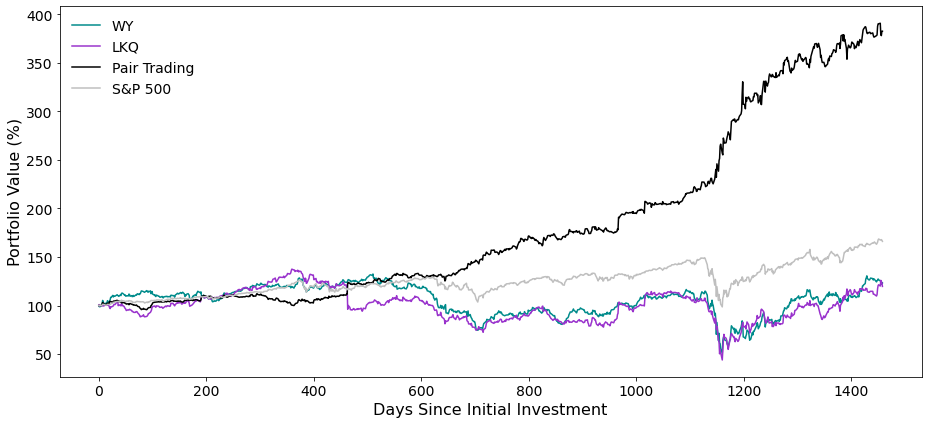

In [7]:
plt.figure(figsize=(13,6))

#Get the general S&P 500 index value to include for comparison
c.execute("SELECT * FROM GSPC_stats WHERE date_int < 1461")
SP500_df = pd.DataFrame(c.fetchall(), columns = [x[0] for x in c.description])

BaselineFunds  = []
BaselineFunds1 = []
BaselineFunds2 = []

for i in range(len(stats1_df)):
    BaselineFunds.append(InitFunds*SP500_df['Close'][i]/SP500_df['Open'][0])
    BaselineFunds1.append(InitFunds*stats1_df['Close'][i]/stats1_df['Open'][0])
    BaselineFunds2.append(InitFunds*stats2_df['Close'][i]/stats2_df['Open'][0])
BaselineFunds = np.array(BaselineFunds)
BaselineFunds1 = np.array(BaselineFunds1)
BaselineFunds2 = np.array(BaselineFunds2)
CurrentValues = np.array(CurrentValues)

plt.plot(stats1_df['date_int'], 100.0*BaselineFunds1/InitFunds, color='darkcyan', label=Symbol1)
plt.plot(stats2_df['date_int'], 100.0*BaselineFunds2/InitFunds, color='darkorchid', label=Symbol2)
plt.plot(stats1_df['date_int'], 100.0*CurrentValues/InitFunds, color='k', label='Pair Trading')
plt.plot(stats1_df['date_int'], 100.0*BaselineFunds/InitFunds, color='0.75', label='S&P 500')

plt.xlabel('Days Since Initial Investment',fontsize=16)
plt.ylabel('Portfolio Value (%)',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14,loc='best',frameon=False)


plt.tight_layout()
plt.show()

In [8]:
BaselineFund  =  InitFunds*SP500_df['Open'][len(SP500_df)-1]/SP500_df['Open'][0]
BaselineFund1 =  0.5*InitFunds*stats1_df['Open'][len(stats1_df)-1]/stats1_df['Open'][0]
BaselineFund2 =  0.5*InitFunds*stats2_df['Open'][len(stats2_df)-1]/stats2_df['Open'][0]

print('Test Period Yields')
print('Pair Trading\t'+Symbol1+'\t\t'+Symbol2+'\t\t'+Symbol1+'+'+Symbol2+'\t\tS&P 500')
print('$'+str(round(AvailableFunds,2))+'\t$'+str(round(2*BaselineFund1,2))+'\t$'+str(round(2*BaselineFund2,2))+'\t$'+str(round(BaselineFund1+BaselineFund2,2))+'\t$'+str(round(BaselineFund,2)))
print(str(round(100.0*AvailableFunds/InitFunds,2))+'%\t\t'+str(round(100.0*2*BaselineFund1/InitFunds,2))+'%\t\t'+str(round(100.0*2*BaselineFund2/InitFunds,2))+'%\t\t'+str(round(100.0*(BaselineFund1+BaselineFund2)/InitFunds,2))+'%\t\t'+str(round(100.0*(BaselineFund)/InitFunds,2))+'%')


Test Period Yields
Pair Trading	WY		LKQ		WY+LKQ		S&P 500
$382513.0	$122748.94	$122517.4	$122633.17	$166967.67
382.51%		122.75%		122.52%		122.63%		166.97%
